In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree, metrics

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('Suicide_Detection_Cleaned.csv')

In [3]:
df = df.dropna()

In [4]:
df['class'][df['class'] == 'suicide'] = 1
df['class'][df['class'] == 'non-suicide'] = 0

C:\Users\BETH&A~1\AppData\Local\Temp/ipykernel_14380/3149362354.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class'][df['class'] == 'suicide'] = 1
C:\Users\BETH&A~1\AppData\Local\Temp/ipykernel_14380/3149362354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class'][df['class'] == 'non-suicide'] = 0


In [5]:
df['class'] = df['class'].astype(int)

In [6]:
vectorizer = CountVectorizer(min_df=3)
X = vectorizer.fit_transform(df['clean_text'])
X = X.tocsc() 
y = df['class']

In [7]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.25, random_state=12)

In [8]:
nbcv = MultinomialNB(alpha = 0.2)
nbcv.fit(X_train1, y_train1)

MultinomialNB(alpha=0.2)

In [9]:
y_train_pred1 = nbcv.predict(X_train1)
y_pred1 = nbcv.predict(X_test1)

In [10]:
training_accuracy_nbcv = nbcv.score(X_train1, y_train1)
test_accuracy_nbcv = nbcv.score(X_test1, y_test1)

In [11]:
print("Accuracy on training data: {:2f}".format(training_accuracy_nbcv))
print("Accuracy on test data:     {:2f}".format(test_accuracy_nbcv))

Accuracy on training data: 0.918362
Accuracy on test data:     0.912347


In [12]:
from sklearn import tree, metrics
accuracy_nbcv = metrics.accuracy_score(y_test1,y_pred1)
balanced_accuracy_nbcv = metrics.balanced_accuracy_score(y_test1,y_pred1)
precision_nbcv = metrics.precision_score(y_test1,y_pred1, pos_label = 1)
recall_nbcv = metrics.recall_score(y_test1,y_pred1, pos_label = 1)
f1_nbcv = metrics.f1_score(y_test1, y_pred1, pos_label = 1)
roc_auc_nbcv = metrics.roc_auc_score(y_test1, y_pred1)
print("Accuracy:", accuracy_nbcv)
print("Balanced accuracy:", balanced_accuracy_nbcv)
print('Precision score' , precision_nbcv)
print('Recall score' , recall_nbcv)
print('F1 score' , f1_nbcv)
print('ROC_AUC Score' , roc_auc_nbcv)

Accuracy: 0.9123472325168497
Balanced accuracy: 0.9124044626011576
Precision score 0.8801413472558258
Recall score 0.9544309041322885
F1 score 0.9157819771774954
ROC_AUC Score 0.9124044626011576


In [13]:
from sklearn.metrics import confusion_matrix
tn_nbcv, fp_nbcv, fn_nbcv, tp_nbcv = confusion_matrix(y_test1, y_pred1).ravel()
print(f'True Suicide: {tp_nbcv}')
print(f'False Suicide: {fp_nbcv}')
print(f'True Non-Suicide: {tn_nbcv}')
print(f'False Non-Suicide: {fn_nbcv}')

True Suicide: 27647
False Suicide: 3765
True Non-Suicide: 25281
False Non-Suicide: 1320


In [14]:
pd.DataFrame(confusion_matrix(y_test1, y_pred1), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,25281,3765
Actual Suicide,1320,27647


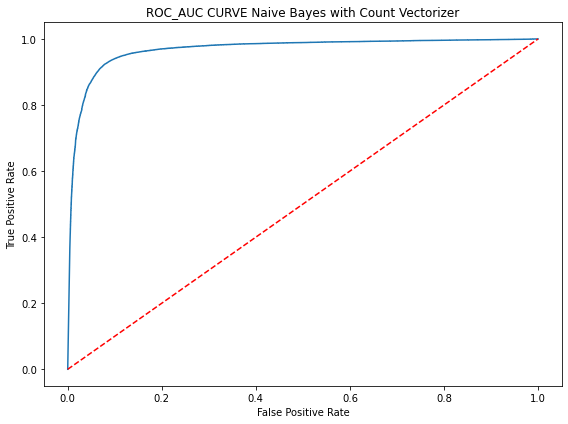

In [15]:
y_pred_proba1 = nbcv.predict_proba(X_test1)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(y_test1,  y_pred_proba1)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr1,tpr1)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Naive Bayes with Count Vectorizer")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC Naive Bayes with Count Vectorizer.png')

In [16]:
# What do we care about?  
# Definitions:  1) True Positive:  Predicted as Suicide and Actually were suicide
#               2) True Negative:  Predicted as Non-Suicide and were non-suicide
#               3)  False Positive:  Predicted as Suicide and were not suicie
#               4)  False Negative:  Predicted as non-suicide and WERE ACTUALLY SUICIDE

#    precision = tp/(tp+fp)
#    recall =  tp/(tp+fn)

# F1 = Harmonic mean of precision and recall
# Fbeta adjusts the weighting of precision and recall F2 increases importance of recall F0.5 increases weighting of precision

#  Ultimately if we are predicting who is suicidal and we predict :
#  False Positive...perhaps attention is paid to an individual who is not really suicidal
#  False Negative...someone who is really suicidal is ignored

#  THEREFORE  we care more about False Negative 
#  any Fbeta score should weigh RECALL more than precision  

In [17]:
from sklearn.metrics import classification_report

def precision_recall(model, X_test, y_test, threshold, beta = 0.5):
    
    y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)
    matrix = confusion_matrix(y_test, y_pred)
    
    #print(threshold,'\n', matrix)
    
    tn = matrix[0,0]# pets that were predicted to get adopted and did
    tp = matrix[1,1]# pets that were predicted not to get adopted and didn't
    fp = matrix[0,1]# pets that were predicted not to get adopted but did
    fn = matrix[1,0]# pets that were predicted to get adopted but didn't
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    f_beta = fbeta_score(y_test, y_pred, beta=beta)
    
    return([precision, recall, f_beta])

In [18]:
y_pred = (nbcv.predict_proba(X_test1)[:,1] >= 0.38).astype(bool)

print(classification_report(y_test1,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90     29046
           1       0.87      0.96      0.91     28967

    accuracy                           0.91     58013
   macro avg       0.91      0.91      0.91     58013
weighted avg       0.91      0.91      0.91     58013



In [19]:
y_pred = (nbcv.predict_proba(X_test1)[:,1] >= 0.5).astype(bool)

print(classification_report(y_test1,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91     29046
           1       0.88      0.95      0.92     28967

    accuracy                           0.91     58013
   macro avg       0.92      0.91      0.91     58013
weighted avg       0.92      0.91      0.91     58013



In [20]:
from sklearn import tree, metrics
accuracy_nbcv = metrics.accuracy_score(y_test1,y_pred1)
balanced_accuracy_nbcv = metrics.balanced_accuracy_score(y_test1,y_pred1)
precision_nbcv = metrics.precision_score(y_test1,y_pred1, pos_label = 1)
recall_nbcv = metrics.recall_score(y_test1,y_pred1, pos_label = 1)
f1_nbcv = metrics.f1_score(y_test1, y_pred1, pos_label = 1)
roc_auc_nbcv = metrics.roc_auc_score(y_test1, y_pred1)
print("Accuracy:", accuracy_nbcv)
print("Balanced accuracy:", balanced_accuracy_nbcv)
print('Precision score' , precision_nbcv)
print('Recall score' , recall_nbcv)
print('F1 score' , f1_nbcv)
print('ROC_AUC Score' , roc_auc_nbcv)

Accuracy: 0.9123472325168497
Balanced accuracy: 0.9124044626011576
Precision score 0.8801413472558258
Recall score 0.9544309041322885
F1 score 0.9157819771774954
ROC_AUC Score 0.9124044626011576


# Thresholding

In [21]:
from sklearn import tree, metrics
from sklearn.metrics import fbeta_score
d = []
for i in [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1 ]:
    y_pred = (nbcv.predict_proba(X_test1)[:,1] >= i).astype(bool)
    precision = metrics.precision_score(y_test1,y_pred, pos_label = 1)
    recall = metrics.recall_score(y_test1, y_pred, pos_label = 1)
    f_beta = fbeta_score(y_test1, y_pred, beta=2)
    tn_nbcv, fp_nbcv, fn_nbcv, tp_nbcv = confusion_matrix(y_test1, y_pred).ravel()
    d.append((i, precision, recall, f_beta, tp_nbcv, fp_nbcv, tn_nbcv, fn_nbcv))
 

In [22]:
df_threshold = pd.DataFrame(d, columns = ('Threshold', 'Precision', 'Recall', 'F-2 Score', 'True Positive', 'False Positive', 'True_Negative', 'False Negative'))


In [23]:
df_threshold['FPR'] = df_threshold['False Positive'] / (df_threshold['True_Negative'] + df_threshold['False Positive'])
df_threshold['TPR'] = df_threshold['True Positive'] / (df_threshold['True Positive'] + df_threshold['False Negative'])
df_threshold['TPR - (1-FPR)'] = df_threshold['TPR'] - (1 - df_threshold['FPR'])
df_threshold.sort_values(by = ['TPR - (1-FPR)'], ascending = True).head()

,Threshold,Precision,Recall,F-2 Score,True Positive,False Positive,True_Negative,False Negative,FPR,TPR,TPR - (1-FPR)
20,1.00,0.988352,0.322229,0.372430,9334,110,28936,19633,0.003787,0.322229,-0.673984
19,0.95,0.934972,0.899403,0.906298,26053,1812,27234,2914,0.062384,0.899403,-0.038213
18,0.90,0.926053,0.915663,0.917722,26524,2118,26928,2443,0.072919,0.915663,-0.011419
17,0.85,0.919909,0.924673,0.923716,26785,2332,26714,2182,0.080286,0.924673,0.004959
16,0.80,0.913780,0.931508,0.927908,26983,2546,26500,1984,0.087654,0.931508,0.019162


In [24]:
df_threshold.set_index('Threshold')

,Precision,Recall,F-2 Score,True Positive,False Positive,True_Negative,False Negative,FPR,TPR,TPR - (1-FPR)
Threshold,,,,,,,,,,
0.00,0.499319,1.000000,0.832955,28967,29046,0,0,1.000000,1.000000,1.000000
0.05,0.785116,0.977146,0.931576,28305,7747,21299,662,0.266715,0.977146,0.243861
0.10,0.810156,0.973211,0.935552,28191,6606,22440,776,0.227432,0.973211,0.200643
0.15,0.825995,0.970138,0.937421,28102,5920,23126,865,0.203815,0.970138,0.173953
0.20,0.838058,0.967411,0.938442,28023,5415,23631,944,0.186428,0.967411,0.153840
0.25,0.846893,0.964891,0.938732,27950,5053,23993,1017,0.173965,0.964891,0.138857
0.30,0.854883,0.962751,0.939053,27888,4734,24312,1079,0.162983,0.962751,0.125734
0.35,0.862090,0.960748,0.939251,27830,4452,24594,1137,0.153274,0.960748,0.114023
0.40,0.868217,0.958884,0.939267,27776,4216,24830,1191,0.145149,0.958884,0.104033


(0.0, 1.0)

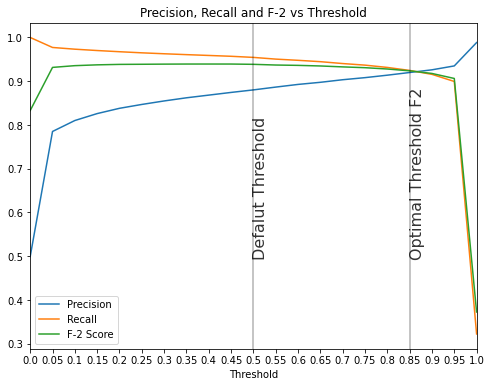

In [25]:
plt.plot(df_threshold['Threshold'], df_threshold[['Precision', 'Recall', 'F-2 Score']])
plt.xticks(df_threshold['Threshold'], df_threshold['Threshold'].values)
plt.axvline(0.85, color='black', alpha=0.3)
plt.text(.85,.5,'Optimal Threshold F2',rotation=90, alpha=0.8, fontsize=16)
plt.axvline(0.5, color='black', alpha=0.3)
plt.text(.5,.5,'Defalut Threshold',rotation=90, alpha=0.8, fontsize=16)
plt.xlabel('Threshold')
plt.legend(df_threshold[['Precision', 'Recall', 'F-2 Score']].columns)
plt.title('Precision, Recall and F-2 vs Threshold')
plt.xlim(0, 1)

In [91]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
scaler = MinMaxScaler()
scaler.fit(df1)
df_scaled = scaler.transform(df1)
scaled_features_df = pd.DataFrame(df_scaled, index=df1.index, columns=df1.columns)

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizor_tfid = TfidfVectorizer(min_df=0)
text_matrix12 = vectorizor_tfid.fit_transform(df['clean_text'])
text_matrix12 = text_matrix12.tocsc() 
length = scaled_features_df['length'].values[:, None]
sentiment = scaled_features_df['sentiment'].values[:, None]
reading_level = scaled_features_df['flesch_kincaid'][:, None]
repetition = scaled_features_df['repetition'][:, None]
first = hstack((text_matrix12, length))
second = hstack((first, sentiment))
third = hstack((second, reading_level))
X_tfid12 = hstack((third, sentiment))

y_tfid12 = df['class']

C:\Users\BETH&A~1\AppData\Local\Temp/ipykernel_14380/1107040348.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  reading_level = scaled_features_df['flesch_kincaid'][:, None]
C:\Users\BETH&A~1\AppData\Local\Temp/ipykernel_14380/1107040348.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  repetition = scaled_features_df['repetition'][:, None]


In [93]:
X_train12, X_test12, y_train12, y_test12 = train_test_split(X_tfid12, y_tfid12, test_size=0.25, random_state=12)

In [94]:
lr_tfidi = LogisticRegression()
lr_tfidi.fit(X_test12, y_test12)

C:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [95]:
y_train_pred12 = lr_tfidi.predict(X_train12)
y_pred12 = lr_tfidi.predict(X_test12)

In [96]:
from sklearn.metrics import confusion_matrix
tn_lr_tfidi, fp_lr_tfidi, fn_lr_tfidi, tp_lr_tfidi = confusion_matrix(y_test12, y_pred12).ravel()
print(f'True Suicide: {tp_lr_tfidi}')
print(f'False Suicide: {fp_lr_tfidi}')
print(f'True Non-Suicide: {tn_lr_tfidi}')
print(f'False Non-Suicide: {fn_lr_tfidi}')

True Suicide: 26822
False Suicide: 1396
True Non-Suicide: 27650
False Non-Suicide: 2145


Naive Bayes - All Features (Count Vectorizer)

In [26]:
df1 = df[['length', 'sentiment', 'flesch_kincaid', 'repetition', 'class']]
df1.head()

,length,sentiment,flesch_kincaid,repetition,class
0,345,0.100000,24.4,0,1
1,69,0.100000,8.4,0,0
2,48,-0.525000,6.4,0,0
3,30,-0.291667,-1.5,0,1
4,1281,-0.228461,74.7,2,1


In [27]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
scaler = MinMaxScaler()
scaler.fit(df1)
df_scaled = scaler.transform(df1)
scaled_features_df = pd.DataFrame(df_scaled, index=df1.index, columns=df1.columns)

In [28]:
from scipy.sparse import hstack
vectorizer = CountVectorizer(min_df=3)
text_matrix = vectorizer.fit_transform(df['clean_text'])
text_matrix = text_matrix.tocsc() 
length = scaled_features_df['length'].values[:, None]
sentiment = scaled_features_df['sentiment'].values[:, None]
reading_level = scaled_features_df['flesch_kincaid'][:, None]
repetition = scaled_features_df['repetition'][:, None]
first = hstack((text_matrix, length))
second = hstack((first, sentiment))
third = hstack((second, reading_level))
X = hstack((third, sentiment))

y = df['class']

C:\Users\BETH&A~1\AppData\Local\Temp/ipykernel_14380/2777764568.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  reading_level = scaled_features_df['flesch_kincaid'][:, None]
C:\Users\BETH&A~1\AppData\Local\Temp/ipykernel_14380/2777764568.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  repetition = scaled_features_df['repetition'][:, None]


In [29]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.25, random_state=12)

In [30]:
nbcvi = MultinomialNB(alpha = 0.05)
nbcvi.fit(X_train2, y_train2)

MultinomialNB(alpha=0.05)

In [31]:
y_train_pred2 = nbcvi.predict(X_train2)
y_pred2 = nbcvi.predict(X_test2)

In [32]:
training_accuracy_nbcv = nbcvi.score(X_train2, y_train2)
test_accuracy_nbcv = nbcvi.score(X_test2, y_test2)

In [33]:
print("Accuracy on training data: {:2f}".format(training_accuracy_nbcv))
print("Accuracy on test data:     {:2f}".format(test_accuracy_nbcv))

Accuracy on training data: 0.926429
Accuracy on test data:     0.919863


In [34]:
accuracy_nbcvi = metrics.accuracy_score(y_test2,y_pred2)
balanced_accuracy_nbcvi = metrics.balanced_accuracy_score(y_test2,y_pred2)
precision_nbcvi = metrics.precision_score(y_test2,y_pred2, pos_label = 1)
recall_nbcvi = metrics.recall_score(y_test2,y_pred2, pos_label = 1)
f1_nbcvi = metrics.f1_score(y_test2, y_pred2, pos_label = 1)
roc_auc_nbcvi = metrics.roc_auc_score(y_test2, y_pred2)
print("Accuracy:", accuracy_nbcvi)
print("Balanced accuracy:", balanced_accuracy_nbcvi)
print('Precision score' , precision_nbcvi)
print('Recall score' , recall_nbcvi)
print('F1 score' , f1_nbcvi)
print('ROC_AUC Score' , roc_auc_nbcvi)

Accuracy: 0.9198627893747953
Balanced accuracy: 0.9198987194875261
Precision score 0.89860346184107
Recall score 0.9462837021438189
F1 score 0.9218274453094786
ROC_AUC Score 0.9198987194875261


In [35]:
from sklearn.metrics import confusion_matrix
tn_nbcvi, fp_nbcvi, fn_nbcvi, tp_nbcvi = confusion_matrix(y_test2, y_pred2).ravel()
print(f'True Suicide: {tp_nbcvi}')
print(f'False Suicide: {fp_nbcvi}')
print(f'True Non-Suicide: {tn_nbcvi}')
print(f'False Non-Suicide: {fn_nbcvi}')

True Suicide: 27411
False Suicide: 3093
True Non-Suicide: 25953
False Non-Suicide: 1556


In [36]:
pd.DataFrame(confusion_matrix(y_test2, y_pred2), columns=['Predicted Non-Suicide', "Predicted Suicide"], index=['Actual Non-Suicide', 'Actual Suicide'])

,Predicted Non-Suicide,Predicted Suicide
Actual Non-Suicide,25953,3093
Actual Suicide,1556,27411


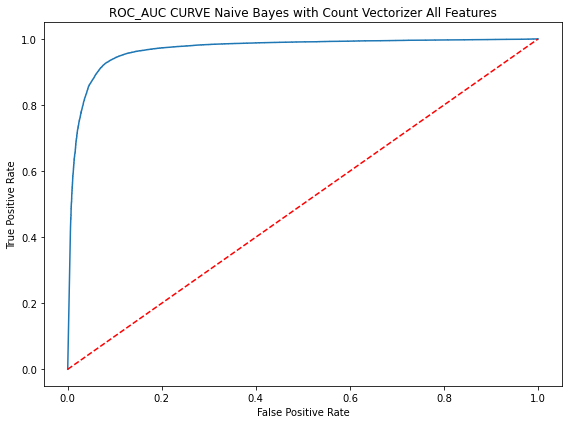

In [37]:
y_pred_proba2 = nbcvi.predict_proba(X_test2)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y_test2,  y_pred_proba2)
plt.rcParams.update({'figure.figsize': (8, 6.0)})
#create ROC curve
plt.plot(fpr2,tpr2)
plt.plot([0, 1], [0, 1],'r--')
plt.title("ROC_AUC CURVE Naive Bayes with Count Vectorizer All Features")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.savefig('ROC_AUC Naive Bayes with Count Vectorizer All features.png')

In [52]:
fire_rain ='just yesterday morning they let me know you were gone suzanne the plans they made put an end to you i walked out this morning and i wrote down this song i just can not remember who to send it to i have seen fire and I have seen rain i have seen sunny days that i thought would never endi have seen lonely times when i could not find a friend but i always thought that i would see you again will you not look down upon me jesus you have got to help me make a stand you have just got to see me through another day my body is aching and my time is at hand and i will not make it any other way oh  i have seen fire and i have seen rain i have seen sunny days that i thought would never end i have seen lonely times when i could not find a friend but i always thought that i would see you again been walking my mind to an easy time my back turned towards the sun lord knows, when the cold wind blows it will turn your head around well there is hours of time on the telephone line to talk about things to come sweet dreams and flying machines in pieces on the ground oh i have seen fire and I have seen rain i  have seen sunny days that i thought would never end i have seen lonely times when i could not find a friend but i always thought that I would see you baby one more time again now thought i would see you one more time again there is just a few things coming my way this time around now thought i would see you thought I would see you fire and rain now'

In [38]:
everybody_hurts ='when your day is long and the night the night is yours alone when you are sure you have had enough of this life well hang on do not let yourself go because everybody cries everybody hurts sometimes ometimes everything is wrong now its time to sing along when your day is night alone hold on hold on if you feel like letting go hold on if you think you have had too much of this life well hang on because everybody hurts take comfort in your friends everybody hurts do not throw your hand oh no do not throw your hand if you feel like you are alone no no no you are not alone if you are on your own in this life the days and nights are long when you think you have had too much of this life to hang on well everybody hurts sometimes everybody cries everybody hurts sometimes and everybody hurts sometimes so hold on hold on hold on hold on hold on hold on hold on hold on everybody hurts'

In [53]:
happy_know_it = 'if you are happy and you know it clap your hands if you are happy and you know it then your face will surely show it if you are happy and you know if clap your hands'

In [54]:
wonderful_world = 'i see trees of green red roses too i see them bloom for me and you and i think to myself what a wonderful world i see skies of blue and clouds of white the bright blessed day the dark sacred night and i think to myself what a wonderful world the colors of the rainbow so pretty in the sky are also on the faces of people going by i see friends shaking hands saying how do you do they are really saying i love you i hear babies crying i watch them grow they willl learn much more than i will ever know and i think to myself what a wonderful world yes i think to myself what a wonderful world ooh yes'

In [55]:
r_roll = 'we are no strangers to love you know the rules and so do i a full commitment is what i am thinking of you would not get this from any other guy i just wanna tell you how i am feeling gotta make you understand never gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you we have known each other for so long your heart has been aching but you are too shy to say it inside we both know what has been going on we know the game and we are gonna play it and if you ask me how i am feeling do not tell me you are too blind to see never gonna give you up never gonna let you down  never gonna run around and desert you never gonna make you cry never gonna say goodbye  never gonna tell a lie and hurt you never gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you we have known each other for so long your heart has been aching but you are too shy to say it inside we both know what has been going on we know the game and we are gonna play it i just wanna tell you how i am feeling gotta make you understand never gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you '

In [50]:
eh = {'song': everybody_hurts}
df_eh = pd.DataFrame(eh, index=[0])
df_eh['class'] = 1

C:\Users\BETH&A~1\AppData\Local\Temp/ipykernel_14380/2796438399.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eh['song'][1] = fire_rain


In [58]:
df_eh

,song,class
0,when your day is long and the night the night ...,0


In [40]:
df1.head()

,length,sentiment,flesch_kincaid,repetition,class
0,345,0.100000,24.4,0,1
1,69,0.100000,8.4,0,0
2,48,-0.525000,6.4,0,0
3,30,-0.291667,-1.5,0,1
4,1281,-0.228461,74.7,2,1


In [41]:
words = df_eh['song'].iloc[0].split(" ")  
count = 0; 
for i in range(len(words)-1):  
    if words[i] == words[i+1]:
        count = count + 1

df_eh['repetition'] = count

In [42]:
from textblob import TextBlob
import textstat
df_eh['length'] = len(df_eh['song'].iloc[0])
df_eh['sentiment'] = TextBlob(df_eh['song'].iloc[0]).polarity
df_eh['flesch_kincaid'] = textstat.flesch_kincaid_grade(df['clean_text'].iloc[0])


In [43]:
df2 = df_eh[['sentiment', 'flesch_kincaid', 'repetition', 'length']]

In [44]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
scaler = MinMaxScaler()
scaler.fit(df2)
df_scaled = scaler.transform(df2)
scaled_features_df = pd.DataFrame(df_scaled, index=df2.index, columns=df2.columns)

In [45]:
from scipy.sparse import hstack

text_matrix = vectorizer.transform(df_eh['song'])
text_matrix = text_matrix.tocsc() 
length = scaled_features_df['length'].values[:, None]
sentiment = scaled_features_df['sentiment'].values[:, None]
reading_level = scaled_features_df['flesch_kincaid'][:, None]
repetition = scaled_features_df['repetition'][:, None]
first = hstack((text_matrix, length))
second = hstack((first, sentiment))
third = hstack((second, reading_level))
X = hstack((third, sentiment))

y = df_eh['class']

C:\Users\BETH&A~1\AppData\Local\Temp/ipykernel_14380/3444347364.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  reading_level = scaled_features_df['flesch_kincaid'][:, None]
C:\Users\BETH&A~1\AppData\Local\Temp/ipykernel_14380/3444347364.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  repetition = scaled_features_df['repetition'][:, None]


In [46]:
nbcvi.predict(X)

array([1])

In [47]:
nbcvi.predict_proba(X)

array([[0.00144764, 0.99855236]])

In [97]:
dict1 = {'title':['Fire and Rain', 'Everybody Hurts', 'Happy and You Know It', 'Wonderful World', 'Never Gonna Give You Up'],
        'song':[fire_rain, everybody_hurts, happy_know_it, wonderful_world, r_roll],
        'length':[len(fire_rain), len(everybody_hurts), len(happy_know_it), len(wonderful_world), len(r_roll)], 
         'class': [1, 1 ,0, 0, 0]
       }

In [98]:
df_song = pd.DataFrame(dict1)


In [99]:
df_song

,title,song,length,class
0,Fire and Rain,just yesterday morning they let me know you we...,1455,1
1,Everybody Hurts,when your day is long and the night the night ...,886,1
2,Happy and You Know It,if you are happy and you know it clap your han...,165,0
3,Wonderful World,i see trees of green red roses too i see them ...,598,0
4,Never Gonna Give You Up,we are no strangers to love you know the rules...,1741,0


In [100]:

df_song['repetition'] = ''
for item in range(len(df_song)):

    words = df_song['song'].iloc[item].split(" ")  
   
    
    count = 0; 
    for i in range(len(words)-1):  
        if words[i] == words[i+1]:
            count = count + 1

    df_song['repetition'].iloc[item] = count

C:\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [101]:
df_song['flesch_kincaid'] = ''
for i in range(len(df_song)):
    df_song['flesch_kincaid'].iloc[i] = textstat.flesch_kincaid_grade(df_song['song'].iloc[i])


In [102]:
df_song['sentiment'] = ''
for i in range(len(df_song)):
    df_song['sentiment'].iloc[i] = TextBlob(df_song['song'].iloc[i]).polarity

In [103]:
df_song


,title,song,length,class,repetition,flesch_kincaid,sentiment
0,Fire and Rain,just yesterday morning they let me know you we...,1455,1,0,117.5,0.019017
1,Everybody Hurts,when your day is long and the night the night ...,886,1,2,67.6,0.1125
2,Happy and You Know It,if you are happy and you know it clap your han...,165,0,0,11.8,0.725
3,Wonderful World,i see trees of green red roses too i see them ...,598,0,0,47.3,0.373333
4,Never Gonna Give You Up,we are no strangers to love you know the rules...,1741,0,0,139.4,-0.158796


In [104]:
df3 = df_song[['sentiment', 'flesch_kincaid', 'repetition', 'length']]

In [105]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
scaler = MinMaxScaler()
scaler.fit(df3)
df_scaled = scaler.transform(df3)
scaled_features_df = pd.DataFrame(df_scaled, index=df3.index, columns=df3.columns)

In [110]:
from scipy.sparse import hstack

text_matrix =  vectorizor_tfid.transform(df_song['song'])
text_matrix = text_matrix.tocsc() 
length = scaled_features_df['length'].values[:, None]
sentiment = scaled_features_df['sentiment'].values[:, None]
reading_level = scaled_features_df['flesch_kincaid'].values[:, None]
repetition = scaled_features_df['repetition'].values[:, None]
first = hstack((text_matrix, length))
second = hstack((first, sentiment))
third = hstack((second, reading_level))
X_song = hstack((third, sentiment))

y_song = df_song['class']

In [111]:
lr_tfidi.predict(X_song)

array([0, 0, 0, 0, 0])